## Libraries

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import wittgenstein as lw
from rulefit import RuleFit


## Data load and Transformation

In [2]:
df = pd.read_csv(r'synthetic_medical_billing_data_medium.csv', low_memory=False)
df['svc_date'] = pd.to_datetime(df['svc_date'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499334 entries, 0 to 2499333
Data columns (total 14 columns):
 #   Column          Dtype         
---  ------          -----         
 0   visit_id        int64         
 1   procedure_code  object        
 2   svc_date        datetime64[ns]
 3   payer_company   object        
 4   payer_type      object        
 5   clinic          object        
 6   physician_npi   int64         
 7   charge_amt      float64       
 8   allowed_amt     float64       
 9   denial_group    object        
 10  denial_code     object        
 11  appeal_success  object        
 12  denial_flag     int64         
 13  denial          object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(8)
memory usage: 267.0+ MB


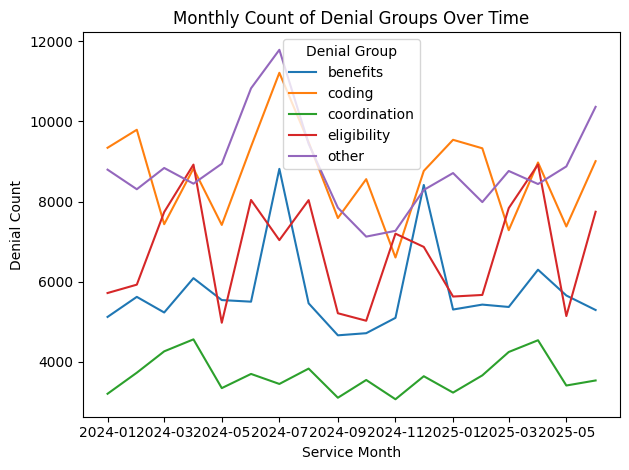


Top 5 frequent values in 'payer_company':
payer_company
Carrier1     119785
Carrier6     119665
Carrier12    119645
Carrier14    119639
Carrier4     119589
Name: count, dtype: int64

Top 5 frequent values in 'payer_type':
payer_type
Commercial    2262331
Medicaid       119212
Medicare       117791
Name: count, dtype: int64

Top 5 frequent values in 'clinic':
clinic
Saint Marys Clinic      501166
Lakeside Medical        500156
Downtown Health         499910
Saint Lukes Hospital    499724
Northside Clinic        498378
Name: count, dtype: int64

Top 5 frequent values in 'procedure_code':
procedure_code
99214    260311
99213    212177
99232    173113
36415    163760
99308    145366
Name: count, dtype: int64

Top 5 frequent values in 'denial':
denial
no     1893131
yes     606203
Name: count, dtype: int64

Top 5 frequent values in 'denial_code':
denial_code
50     66478
197    51837
38     51443
204    48825
B16    45675
Name: count, dtype: int64

Top 5 frequent values in 'appeal_success'

In [3]:
monthly = (df.groupby([df['svc_date'].dt.to_period('M'), 'denial_group']).size().reset_index(name='count'))

monthly['svc_date'] = monthly['svc_date'].dt.to_timestamp()

pivoted = monthly.pivot(index='svc_date', columns='denial_group', values='count').fillna(0)

# 6. Plot each denial group’s monthly trend
plt.figure()
for group in pivoted.columns:
    plt.plot(pivoted.index, pivoted[group], label=f'{group}')

plt.xlabel('Service Month')
plt.ylabel('Denial Count')
plt.title('Monthly Count of Denial Groups Over Time')
plt.legend(title='Denial Group')
plt.tight_layout()
plt.show()
cat_cols = df[['payer_company', 'payer_type', 'clinic', 'procedure_code', 'denial', 'denial_code', 'appeal_success']].columns
for col in cat_cols:
    print(f"\nTop 5 frequent values in '{col}':")
    print(df[col].value_counts().head(5))

In [4]:
df['denial_flag'] = df['denial_code'].apply(lambda x: 1 if pd.notna(x) else 0)
df['physician_npi'] = df['physician_npi'].astype(str)
features = ['payer_company', 'payer_type',
       'clinic', 'physician_npi', 'procedure_code']

# Models

In [5]:
import pandas as pd
import numpy as np
from rulefit import RuleFit

# ─────────────────────────────────────────────────────────────
# 0) Prepare data & features
# ─────────────────────────────────────────────────────────────
# assume df, features, df['denial_flag'], df['allowed_amt'] exist

# collapse rare categories (keep top 20 levels)
card_limit = 50
for col in features:
    top_levels = df[col].value_counts().nlargest(card_limit).index
    df[col] = df[col].where(df[col].isin(top_levels), 'Other')

# one-hot + downcast
X_df = pd.get_dummies(df[features], drop_first=True).astype(np.float32)
X    = X_df.values
y    = (df['denial_flag'] * df['allowed_amt']).astype(np.float32).values

# ─────────────────────────────────────────────────────────────
# 1) Fit RuleFit regressor
# ─────────────────────────────────────────────────────────────
rf = RuleFit(tree_size=4,max_rules=1100, random_state=42)
rf.fit(X, y, feature_names=X_df.columns)

# ─────────────────────────────────────────────────────────────
# 2) Extract only positive‐coef “rule” entries
# ─────────────────────────────────────────────────────────────
rules = rf.get_rules().query("coef>0").copy()

# mark presence of '>' vs '<' in the rule text
rules['has_gt'] = rules['rule'].str.contains(r'>')
rules['has_lt'] = rules['rule'].str.contains(r'<')

# ─────────────────────────────────────────────────────────────
# 3) Split into two sets:
#    A) Mixed rules: both presence (>0.5) & absence (<=0.5)
#    B) Pure-positive: at least one presence, no absence
# ─────────────────────────────────────────────────────────────
mixed     = rules[rules['has_gt'] & rules['has_lt']].copy()
pure_pos  = rules[rules['has_gt'] & ~rules['has_lt']].copy()

# ─────────────────────────────────────────────────────────────
# 4) Compute impact and take top 5 of each
# ─────────────────────────────────────────────────────────────
for df_group in (mixed, pure_pos):
    df_group['impact'] = df_group['coef'] * df_group['support']

top_mixed    = mixed.sort_values('impact', ascending=False).head(20)
top_pure_pos = pure_pos.sort_values('impact', ascending=False).head(20)

# ─────────────────────────────────────────────────────────────
# 5) Display
# ─────────────────────────────────────────────────────────────
print("=== Top 20 MIXED (> & <) Rules ===")
print(top_mixed[['rule','coef','support','impact']], "\n\n")

print("=== Top 20 PURE-POSITIVE (has > only) Rules ===")
print(top_pure_pos[['rule','coef','support','impact']])


=== Top 20 MIXED (> & <) Rules ===
                                                  rule      coef   support  \
376  clinic_Northside Clinic > 0.5 & physician_npi_...  2.359676  0.196035   
741  procedure_code_99232 > 0.5 & clinic_Northside ...  2.074629  0.052686   
130  procedure_code_99306 <= 0.5 & procedure_code_9...  0.490920  0.190297   
206  payer_company_Carrier10 > 0.5 & clinic_Northsi...  0.642247  0.034324   
207  procedure_code_99349 > 0.5 & procedure_code_99...  2.496605  0.007303   
378  payer_company_Carrier6 <= 0.5 & procedure_code...  3.057756  0.005321   
326  procedure_code_99291 > 0.5 & procedure_code_99...  1.871508  0.004486   
670  procedure_code_93306 > 0.5 & clinic_Northside ...  2.405262  0.002504   
635  procedure_code_99291 > 0.5 & clinic_Saint Luke...  1.380776  0.003756   
268  procedure_code_99223 > 0.5 & procedure_code_99...  7.798815  0.000417   
646  payer_company_Carrier9 <= 0.5 & procedure_code...  0.817616  0.003756   
256  procedure_code_93306 > 0

In [6]:
rules.to_csv(r'denial_rules_AA.csv', index=False)

In [7]:
top_mixed = top_mixed[['rule','coef','support','impact']]
top_mixed

,rule,coef,support,impact
376,clinic_Northside Clinic > 0.5 & physician_npi_...,2.359676,0.196035,0.462580
741,procedure_code_99232 > 0.5 & clinic_Northside ...,2.074629,0.052686,0.109305
130,procedure_code_99306 <= 0.5 & procedure_code_9...,0.490920,0.190297,0.093421
206,payer_company_Carrier10 > 0.5 & clinic_Northsi...,0.642247,0.034324,0.022045
207,procedure_code_99349 > 0.5 & procedure_code_99...,2.496605,0.007303,0.018233
378,payer_company_Carrier6 <= 0.5 & procedure_code...,3.057756,0.005321,0.016270
326,procedure_code_99291 > 0.5 & procedure_code_99...,1.871508,0.004486,0.008396
670,procedure_code_93306 > 0.5 & clinic_Northside ...,2.405262,0.002504,0.006023
635,procedure_code_99291 > 0.5 & clinic_Saint Luke...,1.380776,0.003756,0.005186
268,procedure_code_99223 > 0.5 & procedure_code_99...,7.798815,0.000417,0.003255


In [8]:
top_pure_pos = top_pure_pos[['rule','coef','support','impact']]
top_pure_pos

,rule,coef,support,impact
217,clinic_Saint Marys Clinic > 0.5,0.359294,0.201878,0.072533
389,payer_company_Carrier8 > 0.5,0.983434,0.047261,0.046478
367,clinic_Saint Marys Clinic > 0.5 & procedure_co...,4.151415,0.002087,0.008662
526,payer_company_Carrier8 > 0.5 & procedure_code_...,12.419132,0.000313,0.003887
417,payer_company_Medicare > 0.5 & procedure_code_...,2.939273,0.000417,0.001227
744,procedure_code_93306 > 0.5 & payer_company_Car...,1.232773,0.000730,0.000900
455,procedure_code_93306 > 0.5 & payer_company_Car...,1.166359,0.000313,0.000365
596,physician_npi_1922069012 > 0.5,0.016909,0.002713,0.000046


In [9]:
import re
from collections import defaultdict

# list your original features before one‑hot
base_vars = [
    'procedure_code','payer_company','payer_type',
    'clinic','physician_npi','denial_group','denial_code'
]

def prune_by_base_keep_gt(rule_str, base_vars):
    # split clauses (RuleFit uses ' & ')
    clauses = [c.strip() for c in rule_str.split('&')]
    
    # bucket clauses by base var
    buckets = defaultdict(list)
    for c in clauses:
        # extract feature name
        m = re.match(r"(.+?)\s*(<=|>)\s*([0-9\.]+)", c)
        if not m:
            continue
        full_feat = m.group(1)
        # find which base var it belongs to
        base = next((b for b in base_vars if full_feat.startswith(b + "_")), 
                    full_feat if full_feat in base_vars else None)
        if base is None: 
            base = full_feat
        buckets[base].append(c)
    
    pruned = []
    for base, cls in buckets.items():
        if len(cls) > 1:
            # keep only the presence checks
            gt_only = [c for c in cls if '>' in c]
            if gt_only:
                pruned.extend(gt_only)
            else:
                # fallback: keep first clause
                pruned.append(cls[0])
        else:
            pruned.append(cls[0])
    
    return " & ".join(pruned)

# Apply it to your positive rules:
rules2 = rf.get_rules().query("coef>0").copy()
rules2['pruned'] = rules2['rule'].apply(lambda r: prune_by_base_keep_gt(r, base_vars))

print(rules2[['rule','pruned']].head(20))


                                                  rule  \
0                              payer_company_Carrier10   
2                              payer_company_Carrier12   
3                              payer_company_Carrier13   
5                              payer_company_Carrier15   
7                              payer_company_Carrier17   
8                              payer_company_Carrier18   
9                              payer_company_Carrier19   
13                              payer_company_Carrier5   
15                              payer_company_Carrier7   
16                              payer_company_Carrier8   
19                              payer_company_Medicare   
21                                 payer_type_Medicare   
25                           clinic_Saint Marys Clinic   
110                               procedure_code_99308   
122                               procedure_code_G0439   
125                               procedure_code_Other   
130  procedure

In [10]:
rules2

,rule,type,coef,support,importance,pruned
0,payer_company_Carrier10,linear,2.431044e+00,1.000000,5.156455e-01,
2,payer_company_Carrier12,linear,3.259432e+00,1.000000,6.958650e-01,
3,payer_company_Carrier13,linear,1.246508e+00,1.000000,2.645867e-01,
5,payer_company_Carrier15,linear,5.942316e-01,1.000000,1.262870e-01,
7,payer_company_Carrier17,linear,3.028566e+00,1.000000,6.451945e-01,
8,payer_company_Carrier18,linear,3.135307e+00,1.000000,6.678435e-01,
9,payer_company_Carrier19,linear,1.220983e+00,1.000000,2.606100e-01,
13,payer_company_Carrier5,linear,2.679045e+00,1.000000,5.696628e-01,
15,payer_company_Carrier7,linear,3.024210e+00,1.000000,6.452649e-01,
16,payer_company_Carrier8,linear,2.247724e+00,1.000000,4.779922e-01,


|--- procedure_code_99223 <= 0.50
|   |--- procedure_code_99291 <= 0.50
|   |   |--- procedure_code_99233 <= 0.50
|   |   |   |--- procedure_code_99214 <= 0.50
|   |   |   |   |--- procedure_code_93306 <= 0.50
|   |   |   |   |   |--- procedure_code_99213 <= 0.50
|   |   |   |   |   |   |--- value: [12.71]
|   |   |   |   |   |--- procedure_code_99213 >  0.50
|   |   |   |   |   |   |--- value: [21.35]
|   |   |   |   |--- procedure_code_93306 >  0.50
|   |   |   |   |   |--- payer_company_Carrier7 <= 0.50
|   |   |   |   |   |   |--- value: [51.05]
|   |   |   |   |   |--- payer_company_Carrier7 >  0.50
|   |   |   |   |   |   |--- value: [77.32]
|   |   |   |--- procedure_code_99214 >  0.50
|   |   |   |   |--- payer_company_Carrier8 <= 0.50
|   |   |   |   |   |--- payer_company_Carrier7 <= 0.50
|   |   |   |   |   |   |--- value: [20.82]
|   |   |   |   |   |--- payer_company_Carrier7 >  0.50
|   |   |   |   |   |   |--- value: [32.94]
|   |   |   |   |--- payer_company_Carrier8 > 

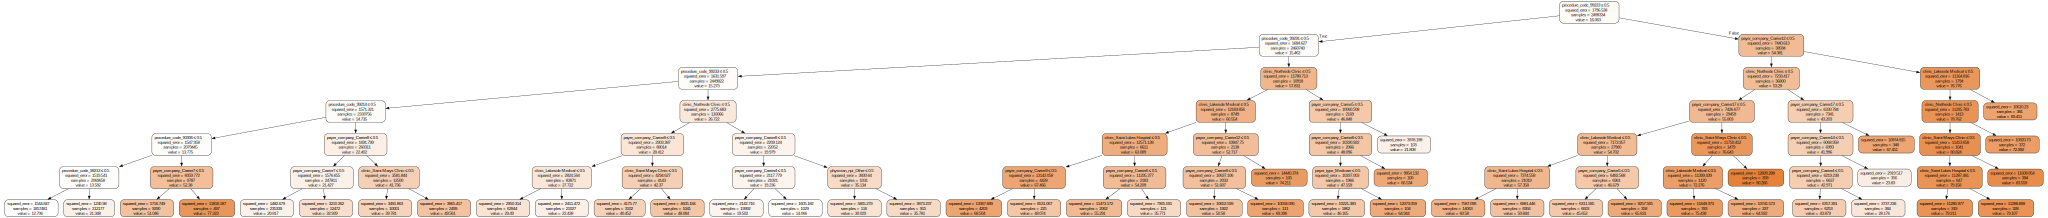

In [11]:
from sklearn.tree import DecisionTreeRegressor, export_text
import pandas as pd

# 1) Build your “benefit” target
df['denial_num'] = df['denial'].map({'no':0,'yes':1})
df['benefit']    = df['denial_num'] * df['allowed_amt']
features = ['payer_company', 'payer_type',
       'clinic', 'physician_npi', 'procedure_code']
# 2) One-hot encode & train
X = pd.get_dummies(df[features], drop_first=True)
y = df['benefit']

rgr = DecisionTreeRegressor(
    max_depth=6,         # keep it interpretable
    min_samples_leaf=100,
    random_state=42
)
rgr.fit(X, y)

# 3) Export rules
print(export_text(rgr, feature_names=X.columns))

from sklearn.tree import export_graphviz
import graphviz

# 1) Export to DOT format
dot_data = export_graphviz(
    rgr,
    out_file=None,
    feature_names=X.columns,
    class_names=['no denial','denial'],
    filled=True,
    rounded=True,
    special_characters=True
)

# 2) Render with graphviz
graph = graphviz.Source(dot_data)
graph.render("denial_tree", format="pdf")   # saves denial_tree.pdf
graph                                            # in Jupyter, displays inline


In [12]:
df.columns

Index(['visit_id', 'procedure_code', 'svc_date', 'payer_company', 'payer_type',
       'clinic', 'physician_npi', 'charge_amt', 'allowed_amt', 'denial_group',
       'denial_code', 'appeal_success', 'denial_flag', 'denial', 'denial_num',
       'benefit'],
      dtype='object')

In [13]:
from interpret.glassbox import ExplainableBoostingRegressor
import pandas as pd

# 1) Target = expected benefit per claim
y = df['denial_flag'] * df['allowed_amt']
X = df[features]

# 2) Fit EBM
ebm = ExplainableBoostingRegressor(
    interactions=10,
    random_state=42
)
ebm.fit(X, y)

# 3) Global importances & plots
ebm_global = ebm.explain_global()
ebm_global.visualize()   # pops up plots of each feature’s effect


## XGBClassifier

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import xgboost as xgb

# 1) Prepare DataFrame
# — replace this with your actual data load
# df = pd.read_csv('your_billing_data.csv')
df = df[df['denial_group'].notnull()].copy()
df['success'] = df['appeal_success'].astype(int)
df['svc_date'] = pd.to_datetime(df['svc_date'])
df['svc_year']  = df['svc_date'].dt.year
df['svc_month'] = df['svc_date'].dt.month
df['svc_day']   = df['svc_date'].dt.day

num_feats = ['allowed_amt','svc_year','svc_month','svc_day']
cat_feats = ['procedure_code','payer_company','payer_type',
             'clinic','physician_npi','denial_group','denial_code']

X = df[num_feats + cat_feats]
y = df['success']

# 2) Train/Test split (stratify on success)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train success counts:\n", y_train.value_counts())
print("Test  success counts:\n", y_test.value_counts())

Train success counts:
 success
1    293617
0    191345
Name: count, dtype: int64
Test  success counts:
 success
1    73404
0    47837
Name: count, dtype: int64


In [15]:


# 3) Manual preprocessing
scaler = StandardScaler().fit(X_train[num_feats])
ohe    = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(X_train[cat_feats])

def preprocess(df_):
    num = scaler.transform(df_[num_feats])
    cat = ohe.transform(df_[cat_feats])
    return np.hstack([num, cat])

X_train_proc = preprocess(X_train)
X_test_proc  = preprocess(X_test)

# 4) Train XGBoost classifier with early stopping (core API)
dtrain = xgb.DMatrix(X_train_proc, label=y_train)
dtest  = xgb.DMatrix(X_test_proc,  label=y_test)

params = {
    'objective':       'binary:logistic',
    'eval_metric':     'auc',
    'eta':              0.1,
    'max_depth':        6,
    'subsample':        0.8,
    'colsample_bytree': 0.8,
    'seed':             42
}

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=20,
    verbose_eval=10
)

# 5) Predict & compute test‐set metrics
p_test = bst.predict(dtest)
y_pred = (p_test >= 0.5).astype(int)

print("=== Classification Metrics on Test Set ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"F1 score:  {f1_score(y_test, y_pred):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, p_test):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 6) Compute expected ROI & rank
test_df = X_test.copy()
test_df['p_success'] = p_test
test_df['exp_roi']   = test_df['p_success'] * test_df['allowed_amt']

top10 = test_df.sort_values('exp_roi', ascending=False).head(10)
print("\nTop 10 Records by Expected ROI:")
print(top10[['p_success','allowed_amt','exp_roi'] + num_feats + cat_feats])


[0]	train-auc:0.77263	test-auc:0.77093
[10]	train-auc:0.77642	test-auc:0.77241
[20]	train-auc:0.77766	test-auc:0.77206
[27]	train-auc:0.77841	test-auc:0.77219
=== Classification Metrics on Test Set ===
Accuracy:  0.714
Precision: 0.848
Recall:    0.643
F1 score:  0.732
ROC AUC:   0.772

Confusion Matrix:
[[39383  8454]
 [26177 47227]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.82      0.69     47837
           1       0.85      0.64      0.73     73404

    accuracy                           0.71    121241
   macro avg       0.72      0.73      0.71    121241
weighted avg       0.75      0.71      0.72    121241


Top 10 Records by Expected ROI:
         p_success  allowed_amt      exp_roi  allowed_amt  svc_year  \
1812504   0.305547     10668.44  3259.714595     10668.44      2024   
1935997   0.932380      2316.25  2159.625637      2316.25      2024   
842050    0.931163      2316.25  2156.807019      2316.25      202